In [1]:
#https://machinelearningmastery.com/expectation-maximization-em-algorithm/
#https://towardsdatascience.com/implement-expectation-maximization-em-algorithm-in-python-from-scratch-f1278d1b9137
#https://jonathan-hui.medium.com/machine-learning-expectation-maximization-algorithm-em-2e954cb76959

In [2]:
from numpy import hstack
from numpy.random import normal
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
from scipy.special import logsumexp

In [3]:
X1 = normal(loc=20, scale=5, size=5000)
X2 = normal(loc=40, scale=5, size=5000)
X = hstack((X1, X2))

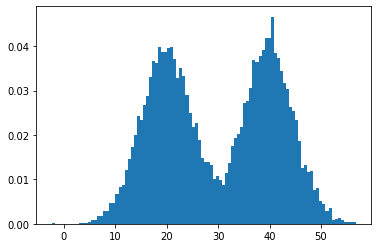

In [4]:
plt.hist(X, bins=100, density=True)
plt.show()

In [5]:
X_temp = np.zeros((5000, 2), dtype=np.float32)
X_temp[:, 0] += X1
X_temp[:, 1] += X2
X = X_temp
X

array([[ 6.904961, 39.02585 ],
       [ 9.076669, 43.52078 ],
       [17.211826, 39.565517],
       ...,
       [21.814175, 45.122913],
       [16.367144, 50.229702],
       [20.49306 , 40.84153 ]], dtype=float32)

In [6]:
def get_random_psd(n):
    x = np.random.normal(0, 1, size=(n, n))
    return np.dot(x, x.transpose())

def initialize_random_params():
    params = {'phi': np.random.uniform(0, 1),
              'mu0': np.random.normal(0, 1, size=(2,)),
              'mu1': np.random.normal(0, 1, size=(2,)),
              'sigma0': get_random_psd(2),
              'sigma1': get_random_psd(2)}
    return params

In [7]:
def p_y(y_class: int, phi: float) -> float:
    return (phi ** y_class) * (1. - phi)**(1-y_class)

In [8]:
def e_step(params):
    p_x_y = [
        stats.multivariate_normal(random_params["mu0"], random_params["sigma0"]).pdf(X),
        stats.multivariate_normal(random_params["mu1"], random_params["sigma1"]).pdf(X)
    ] 
    py = [p_y(0, params['phi']), p_y(1, params['phi'])]
    
    q0 = p_x_y[0]*py[0]
    q1 = p_x_y[1]*py[1]
    denominator = np.sum(q0+q1)
    print(np.sum(q1))
    print(np.sum(q0))
    print(denominator)
    print('------')
    return q0/denominator, q1/denominator#log needed becasue otherwise value is very small, but what is the source of this log?

In [9]:
def m_step(q_0, q_1):
    mu0 = calc_new_mu(X,q_0)
    mu1 = calc_new_mu(X,q_1)
    params = {'phi': np.sum(q_1)/len(X),
              'mu0': mu0,
              'mu1': mu1,
              'sigma0': calc_new_sigma(X,mu0, q_0),
              'sigma1': calc_new_sigma(X,mu1, q_1)}
    
    return params

In [10]:
def calc_new_mu(X, Q):
    numerator = 0
    for xi, q_i in zip(X, Q):
        numerator += xi*q_i
    
    return numerator/(np.sum(Q)+0.0001)

In [11]:
def calc_new_sigma(X, mu, Q):
    numerator = 0
    for x_i, q_i in zip(X, Q):
        diff = X-mu
        numerator += diff.T.dot(diff*q_i[..., np.newaxis])
    return numerator / (np.sum(Q)+0.0001)

In [12]:
def run_em(params, max_iter):
    avg_likelihoods = []
    iter_current = 0
    while True:
        iter_current += 1
        
        q0, q1 = e_step(params)
        avg_likelihoods.append(np.mean(q0+q1))
        if len(avg_likelihoods) > 2 and abs(avg_likelihoods[-1] - avg_likelihoods[-2]) < 0.0001:
            break
        params = m_step(q0, q1)
        print("\tphi: %s\n\tmu_0: %s\n\tmu_1: %s\n\tsigma_0: %s\n\tsigma_1: %s"
               % (params['phi'], params['mu0'], params['mu1'], params['sigma0'], params['sigma1']))
    
        if max_iter == iter_current:
            break
    return params, avg_likelihoods

In [13]:
random_params = initialize_random_params()
params, unsupervised_loglikelihoods = run_em(random_params, 5)
print("total steps: ", len(unsupervised_loglikelihoods))

1.5293694884703196e-256
0.0
1.5293694884703196e-256
------
	phi: 0.0002
	mu_0: [0. 0.]
	mu_1: [10.79369  26.459406]
	sigma_0: [[0. 0.]
 [0. 0.]]
	sigma_1: [[ 539723.12206577  611466.25484088]
 [ 611466.25484088 1031776.35963248]]
3.774258235197694e-260
0.0
3.774258235197694e-260
------
	phi: 0.0002
	mu_0: [0. 0.]
	mu_1: [10.79369  26.459406]
	sigma_0: [[0. 0.]
 [0. 0.]]
	sigma_1: [[ 539723.12206577  611466.25484088]
 [ 611466.25484088 1031776.35963248]]
3.774258235197694e-260
0.0
3.774258235197694e-260
------
total steps:  3


Text(0.5, 1.0, 'unsupervised log likelihoods')

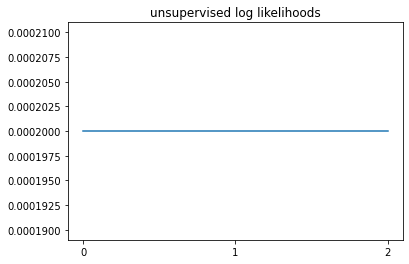

In [16]:
x = np.arange(0, len(unsupervised_loglikelihoods)+1, 1.0)
plt.xticks(x)
plt.plot(unsupervised_loglikelihoods)
plt.title("unsupervised log likelihoods")

In [17]:
unsupervised_loglikelihoods

[0.0002, 0.0002, 0.0002]

In [18]:
params

{'phi': 0.0002,
 'mu0': array([0., 0.], dtype=float32),
 'mu1': array([10.79369 , 26.459406], dtype=float32),
 'sigma0': array([[0., 0.],
        [0., 0.]]),
 'sigma1': array([[ 539723.12206577,  611466.25484088],
        [ 611466.25484088, 1031776.35963248]])}

In [ ]:
# czasami te Q wychodzą jako 0 i teraz muszę dodawać mała liczbę do mianownika -> czy to dobrze?
#skąd się biorą logarytmy u siwei